<a href="https://colab.research.google.com/github/julija-dmrk/data-mining/blob/main/3rd_week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Suicide's data classification

In [2]:
import matplotlib.pyplot as plt   # visualization
import seaborn as sns             # visualization
import numpy as np                # data manipulation
import pandas as pd               # data manipulation, data processing, CSV file I/O (e.g. pd.read_csv
from sklearn import pipeline
# import statsmodels.api as sm
# import statsmodels.formula.api as smf
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.model_selection import KFold, StratifiedKFold, LeaveOneOut, cross_val_score, cross_validate, GridSearchCV, train_test_split

In [3]:
url = "https://raw.githubusercontent.com/VitaT/ML-python/main/data/suicides.csv"
data = pd.read_csv(url)

In [ ]:
data.info()
data.head(5)
data.shape
data.sample(10)


In [5]:
# cleaning up
# spliting country-year column
data['year'] = data["country-year"].str[-4:]
data['country'] = data["country-year"].str.split("\d+", expand = True)[0]
# removing ID and country-year columns
data.drop(["ID", "country-year"], axis=1, inplace=True)

In [6]:
# renaming columns for more convenient use
data.rename(columns={'gdp_for_year ($)':'gdp_year', 'gdp_per_capita ($)':'gdp_capita', 'suicides/100k pop':'suicide_norm', "HDI for year":"hdi_year"}, inplace=True)

In [7]:
data.isna().sum()
# suicide per 100k people can be calculated from suicides_no and population. Let's check it they are the same
# We can overwrite suicide_norm
data["suicide_norm"] = round(data["suicides_no"] / data["population"] * 100000,  2)

## Data's exploration

In [ ]:
data.info()
data.describe(include = ["float", "int"])
data.describe(include = ["object"])

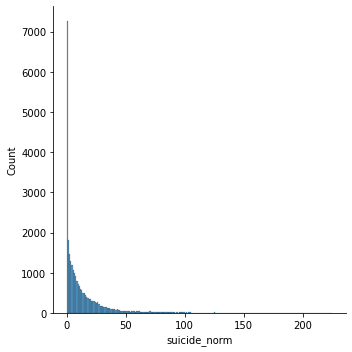

In [9]:
# Q1. what does suicide distribution looks like?
sns.displot(data, x="suicide_norm")
# normalized by population size looks better -- have some very large normalized suicide values, but mostly suicide percentage follows an exponential distribution

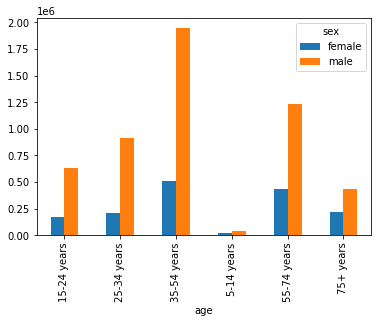

In [10]:
# Q2. What are the number of suicides according to the sex and age?
sp = data.groupby(['age', 'sex'])['suicides_no'].agg('sum').unstack('sex')
sp.plot.bar()
# in all age categories there are more male suicides

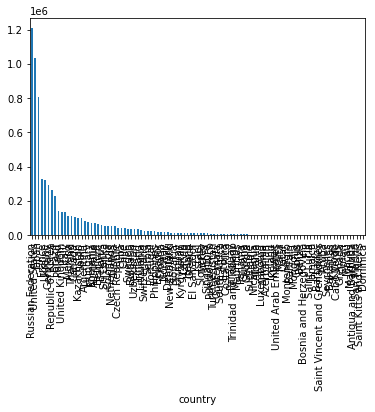

In [11]:
# Q3. What is total and relatice suicide count by the country?
# total suicide number
sp = data.groupby('country')['suicides_no'].agg('sum').sort_values(ascending=False)
sp.plot(kind = "bar")

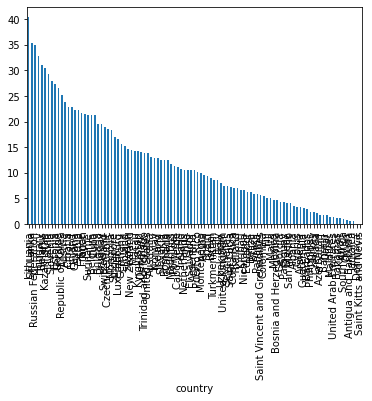

In [12]:
# over all the years normalized by population sum of suicides
sp = data.groupby('country')['suicide_norm'].agg('mean').sort_values(ascending=False)
sp.plot(kind='bar')


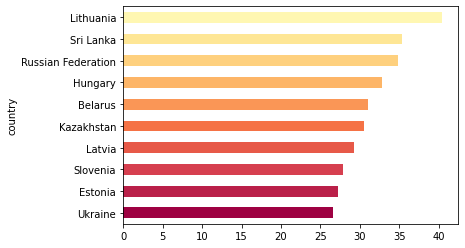

In [13]:
# top 10 countries
col = plt.cm.Spectral(np.linspace(0, 1, 20))
sp.nlargest(10).sort_values().plot(kind='barh', color = col)
top10 = sp.nlargest(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


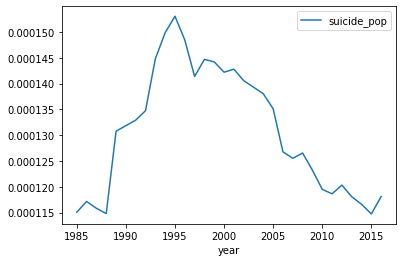

In [17]:
# Which year has the most total Suicides? the least?
tmp = data.groupby("year")["suicides_no"].sum().reset_index().sort_values("suicides_no")
tmp.head()
tmp.tail()
# most 1999, least -- 2016 and 1985

# what if we plot average suicide count off all human population size
sp = data.groupby(["year"])["suicides_no", "population"].sum().reset_index("year")
sp["suicide_pop"] = sp["suicides_no"] / sp["population"]
sp.plot(x = "year", y = "suicide_pop")

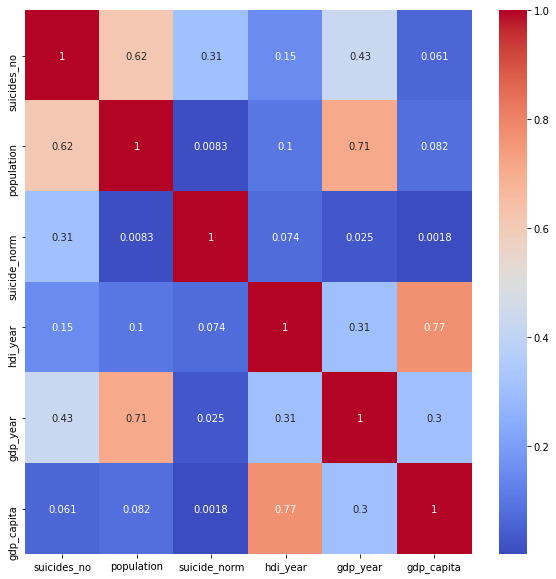

In [18]:
# ## Correlation of features
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax = sns.heatmap(data.corr(), annot=True, cmap='coolwarm')

Text(0.5, 0, 'number of principal components')

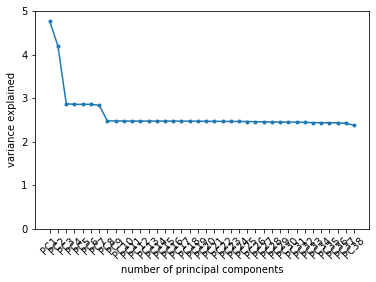

In [19]:
# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# create PCA estimator
pca = PCA(n_components=0.99)

# clean data
x = data.drop(["gdp_capita", "generation", "country", "hdi_year", "suicides_no", "suicide_norm"], axis = 1)
x = pd.get_dummies(x, columns=["sex", "age", "year"])
scaled_x = StandardScaler().fit_transform(x)

# pca
features_pca = pca.fit_transform(scaled_x)
# variance explained
pca_var_ex = pd.Series(pca.explained_variance_ratio_ * 100)
labels = ["PC" + str(x) for x in range(1, len(pca_var_ex)+1)]

plt.plot(labels, pca_var_ex, marker = ".")
plt.xticks(rotation=45)
plt.ylim(0, 5)
plt.ylabel("variance explained")
plt.xlabel("number of principal components")

Prediction -- Regression

In [20]:
y = np.array(data["suicides_no"])
x = data.drop(["suicides_no", "suicide_norm"], axis = 1)

# we have to many countries, so let's drop country column. 
# generation is also not informative.
# dpg per capita is made from gdp per year and population, so will not use it
# hdi -- has a lot of NAN
x = x.drop(["gdp_capita", "generation", "country", "hdi_year"], axis = 1)
x = pd.get_dummies(x, columns=["sex", "age", "year"])
column_names = x.columns

from sklearn.preprocessing import StandardScaler
scaled_x = StandardScaler().fit_transform(x)
scaled_y = StandardScaler().fit_transform(y.reshape(-1, 1))

In [21]:
# testing and training sets.
x_pca, x_pca_out, y, y_out = train_test_split(features_pca, scaled_y, test_size = 0.2, random_state = 0)
x, x_out, y, y_out = train_test_split(scaled_x, scaled_y, test_size = 0.2, random_state = 0)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


train MSE 0.6298191438754773
test MSE 0.3800685242792668


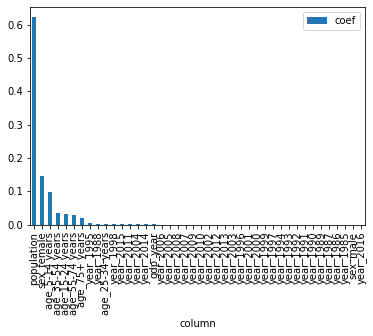

In [22]:
# lasso - because we are trying to reduce predictors count
lasso_cv = LassoCV(cv=KFold(5, True, 0)).fit(x, y)

# regularization parameter
lasso_alpha = lasso_cv.alpha_

# what features were selected?
id = lasso_cv.coef_ != 0
column_names[id]
lasso_cv.coef_[id]
n_features = len(lasso_cv.coef_[id]) # LASSO PADIDINA BAYES'A, KAD SUMAZINTU VARIACIJA
# order them by importance
importance = pd.DataFrame({"coef" : np.abs(lasso_cv.coef_), "column": column_names})
importance = importance.sort_values("coef", ascending=False)
importance.plot(kind = "bar", x = "column", y = "coef")

# test and train values with selected alpha
lasso = Lasso(alpha = lasso_alpha)
lasso.fit(x, y)
print("train MSE", mean_squared_error(lasso.predict(x), y))
print("test MSE", mean_squared_error(lasso.predict(x_out), y_out))

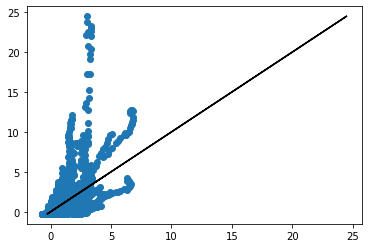

In [23]:
# residuals
y_pred_train = lasso.predict(x)
plt.scatter(y_pred_train, y)
plt.plot(y, y,'k-') # identity line

Because our model predicts just small values (we can see from residuals), we should go back to our features part and maybe try to use PCA, include countries or use more flexible model like KNN 

In [ ]:
# KNN model
# Create a KNN classifie()
knn = KNeighborsRegressor(n_neighbors=5)
# Create a pipeline
pipe = pipeline.Pipeline([("knn", knn)])
# Create space of candidate values
search_space = [{"knn__n_neighbors": [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]}]

# use GridSearchCV to conduct ten-fold cross-validation on KNN classifiers with different values of k
classifier = GridSearchCV(pipe, search_space, cv=KFold(5, True, 0), scoring="neg_mean_squared_error", return_train_score=True).fit(x, y)

classifier.best_estimator_
classifier.best_estimator_.get_params()["knn__n_neighbors"]

classifier.cv_results_
pd.DataFrame(classifier.cv_results_)

# Calculating error for K values between 1 and 12
# for i in k_range:
#     knn = KNeighborsRegressor(n_neighbors=i)
#     scores = cross_val_score(knn, x, y, scoring='neg_mean_squared_error', cv = KFold(10, True, 1))
#     all_scores.append(scores)
#     mean_scores.append(np.mean(scores))

# plt.figure(figsize=(12, 6))
# plt.plot(k_range, all_scores, color='blue', linestyle='dashed', marker='o', markerfacecolor='blue')
# plt.plot(k_range, mean_scores, color='red', linestyle='dashed', marker='o', markerfacecolor='red')
# plt.xlabel('K Value')
# plt.ylabel('score')